### Setup

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import tensorflow            as tf
import tensorflow.keras      as keras
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (
    MaxPooling2D,
    AvgPool2D,
    Input,
    InputLayer,
    Dropout,
    Flatten,
    Dense,
    Lambda,
    GlobalMaxPooling2D,
    Add
)
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot     as plt
import pandas                as pd

import skimage
import skimage.transform
import numpy as np

from tensorflow.keras.optimizers  import SGD, Adam
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils       import plot_model

In [3]:
import sys
sys.path.append('../utilities/')
from utilities import (
    Timer,
    show_image,
    vgg19_process_image,
    class_names,
    Source,
    get_image_from_model,
    load_image,
    precomputed_loss,
    inceptionV3_process_image,
    inceptionV3_deprocess_image,
    Source,
)

# Version 1: Unconstrained

### Setup

In [6]:
width = height = 896

In [7]:
# Load the model
# model_name = 'vgg19-INet-down2-b'
# base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')
base_model = vgg19.VGG19(include_top = True, weights = 'imagenet')
base_model.trainable = False

### Unconstrained VGG19 Dream

In [8]:
input_ = Input(shape = (), batch_size = 1)

image_layer  = Source((1, width, height, 3), name = 'image')

signal = image_layer(input_)

output_layers = {
    'block5_pool' : 1.0
}

outputs = []
def get_summary_function(weight):
    def summary_fn(activation):
        activation = tf.square(activation)
        axes       = tf.range(1, tf.rank(activation))
        activation = tf.reduce_mean(activation, axis = axes)
        return activation * (-1) * weight
    return summary_fn

for layer in base_model.layers:
    if isinstance(layer, InputLayer):
        continue
    elif isinstance(layer, Dense):
        break
    signal = layer(signal)
    if layer.name in output_layers:
        summarizer_layer = Lambda(get_summary_function(output_layers[layer.name]))
        total_activation = summarizer_layer(signal)
        outputs.append(total_activation)
        
if len(outputs) == 1:
    final_output = outputs[0]
else:
    final_output = Add()(outputs)
    

model = Model(inputs = input_, outputs = final_output)

In [9]:
# Load the image
image_path = '../dream-base-images/marco3.png'
image = load_image(image_path, cast = tf.float32)
image = tf.image.resize(image, [width, height])
image = vgg19_process_image(image)
image = tf.expand_dims(image, axis = 0)
image_layer.set_weights([image.numpy()])

In [10]:
dummy       = tf.constant(0, shape = (1,), dtype = tf.float32)
dummy_input = tf.data.Dataset.from_tensors((dummy, dummy))

In [ ]:
adam = tf.optimizers.Adam(learning_rate = 1.0)
model.compile(optimizer = adam, loss = precomputed_loss)
history = model.fit(dummy_input.repeat(100), epochs = 3)

In [ ]:
# Testing locally
img = get_image_from_model(model)
show_image(img)

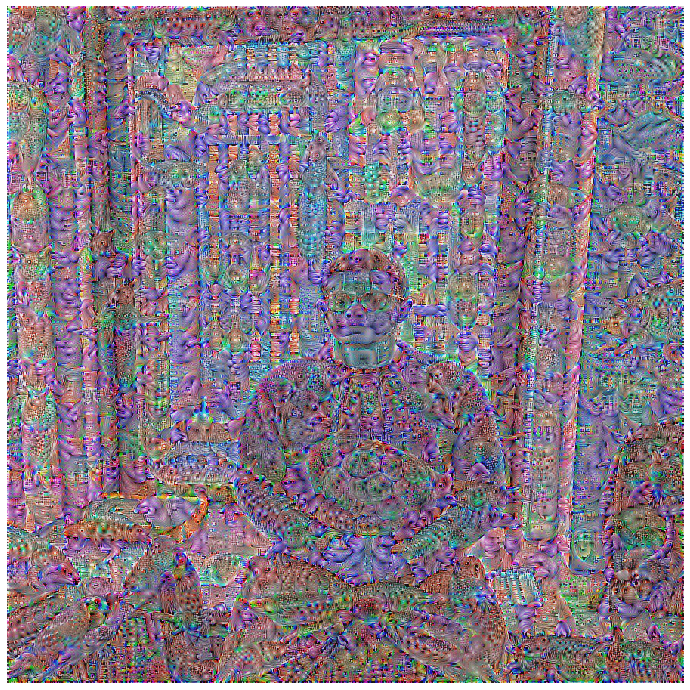

In [54]:
# With ImageNet model
img = get_image_from_model(model)
show_image(img)

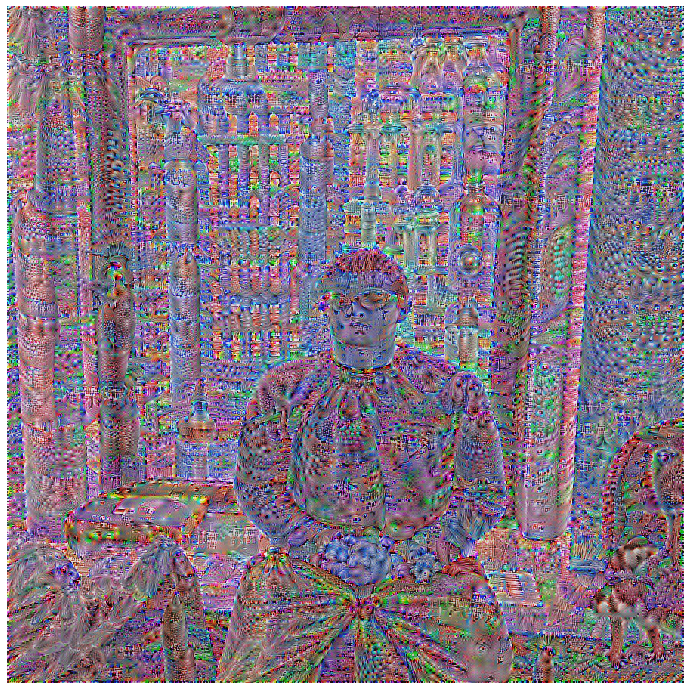

In [47]:
# With art-trained model
img = get_image_from_model(model)
show_image(img)

# Version 2: Unconstrained top-level

In [188]:
width = height = 224

In [190]:
# Load the model
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')
# base_model = vgg19.VGG19(include_top = True, weights = 'imagenet')
base_model.trainable = False

### VGG19 top-level Dream

In [16]:
from tensorflow.keras.constraints import Constraint

class RemainImage(Constraint):
    def __init__(self, rate = 1.0):
        super().__init__()
        self.rate = rate
    
    def __call__(self, kernel):
        return (self.rate       * tf.clip_by_value(kernel, -150, 150) + 
                (1 - self.rate) * kernel)

In [293]:
input_ = Input(shape = (), batch_size = 1)

image_layer  = Source((1, width, height, 3), name = 'image')#, kernel_constraint = RemainImage(0.1))

signal = image_layer(input_)

output_layers = {
    'masked_activations' : 1.0,
    'dense_2'            : 0.01,
    'block3_conv4'       : 0.001
}

outputs = []
def get_summary_function(weight):
    def summary_fn(activation):
#         activation = tf.square(activation)
        axes       = tf.range(1, tf.rank(activation))
        activation = tf.reduce_mean(activation, axis = axes)
        return activation * (-1) * weight
    return summary_fn

# Layer to mask for only certain artists
artist_vector   = tf.convert_to_tensor(class_names == 'Titian', dtype = tf.float32) * 1
artist_selector = lambda activations : tf.tensordot(activations, artist_vector, [-1, -1])
mask_layer      = Lambda(artist_selector, name = 'masked_activations')
include_artist_mask = True

output_count    = 0

for layer in base_model.layers + [mask_layer]:
    if isinstance(layer, InputLayer):
        continue
    elif isinstance(layer, Dropout):
        continue
    elif isinstance(layer, MaxPooling2D):
        layer = AvgPool2D().from_config(layer.get_config())
    elif layer.name == 'dense_2':
        # Top layer requires different activations
        top_config = layer.get_config()
        top_config['activation'] = 'elu'
        top_layer = layer
        layer     = layer.from_config(top_config)
    elif layer.name == 'masked_activations':
        if not include_artist_mask:
            continue

    signal = layer(signal)
    if layer.name in output_layers:
        output_count += 1
        summarizer_layer = Lambda(get_summary_function(output_layers[layer.name]), name = f'compute_gain_{output_count}')
        total_activation = summarizer_layer(signal)
        outputs.append(total_activation)
                
if len(outputs) == 1:
    final_output = outputs[0]
else:
    final_output = Add()(outputs)
    

model = Model(inputs = input_, outputs = final_output)

# Weights for the top layer (with artist activations)
#  were reset; restore them
top_layer.set_weights(base_model.layers[-1].get_weights())

In [295]:
# Load the image
image_path = '../dream-base-images/marco3.png'
image = load_image(image_path, cast = tf.float32)
image = tf.image.resize(image, [width, height])
image = vgg19_process_image(image)
image = tf.expand_dims(image, axis = 0)
image_layer.set_weights([image.numpy()])

In [296]:
dummy       = tf.constant(0, shape = (1,), dtype = tf.float32)
dummy_input = tf.data.Dataset.from_tensors((dummy, dummy))

In [297]:
adam = tf.optimizers.Adam(learning_rate = 10.0)
model.compile(optimizer = adam, loss = precomputed_loss)
history = model.fit(dummy_input.repeat(10), epochs = 3)

Epoch 1/3
10/10 [==============================] - 1s 101ms/step - loss: -1.9889
Epoch 2/3
10/10 [==============================] - 0s 17ms/step - loss: -18.2664
Epoch 3/3
10/10 [==============================] - 0s 17ms/step - loss: -58.9447


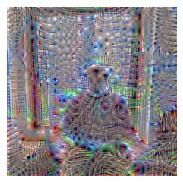

In [298]:
# With art-trained model
img = get_image_from_model(model)
show_image(img)

# Version 3: Attempt to allow larger input images

In [5]:
tf.keras.backend.clear_session()

In [6]:
width = height = 896

tf.keras.backend.clear_session()

# Load the model
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')
# base_model = vgg19.VGG19(include_top = True, weights = 'imagenet')
base_model.trainable = False

### VGG19 top-level Dream

In [7]:
from tensorflow.keras.constraints import Constraint

class RemainImage(Constraint):
    def __init__(self, rate = 1.0):
        super().__init__()
        self.rate = rate
    
    def __call__(self, kernel):
        return (self.rate       * tf.clip_by_value(kernel, -150, 150) + 
                (1 - self.rate) * kernel)

In [8]:
input_ = Input(shape = (), batch_size = 1)

image_layer  = Source((1, width, height, 3), name = 'image', kernel_constraint = RemainImage(0.9))

signal = image_layer(input_)

output_layers = {
#     'masked_activations' : 1.0,
    'dense_2'            : 1.0,
#     'block3_conv4'       : 0.1,
    'block4_conv1'       : 0.1,
    'block5_conv1'       : 0.1,
#    'total_variation'    : (1/width) * (1/height) * (1/256) * 200,
}

# Alias
if 'dense_2' in output_layers:
    output_layers['fc2'] = output_layers['dense_2']

outputs = []
def get_summary_function(weight):
    def summary_fn(activation):
        # activation = tf.square(activation)
        axes       = tf.range(1, tf.rank(activation))
        activation = tf.reduce_mean(activation, axis = axes)
        return activation * (-1) * weight
    return summary_fn
base_model_layers = base_model.layers

# Layer to mask for only certain artists
# artist_vector   = tf.convert_to_tensor(class_names == 'Titian', dtype = tf.float32) * 1
# artist_selector = lambda activations : tf.tensordot(activations, artist_vector, [-1, -1])
# mask_layer      = Lambda(artist_selector, name = 'masked_activations')
# bakse_model_layers.append(mask_layer)

# Add resampling before flattening to allow larger images
flatten_index     = next(filter(
                            lambda i : isinstance(base_model_layers[i], Flatten), 
                            range(len(base_model_layers))
                    ))
resize_layer      = Lambda(lambda tensor : tf.image.resize(tensor, (7,7), method = 'gaussian'),
                           name = 'resize'
                          )
base_model_layers.insert(flatten_index, resize_layer)

max_pool_extracted_layers = False

output_count    = 0
for layer in base_model_layers:
    if isinstance(layer, InputLayer):
        continue
    elif isinstance(layer, Dropout):
        continue
    elif isinstance(layer, MaxPooling2D):
        layer = AvgPool2D().from_config(layer.get_config())
    elif layer.name in ['dense_2', 'fc2']:
        # Top layer requires different activations
        top_config = layer.get_config()
        top_config['activation'] = 'elu'
        top_layer = layer
        layer     = layer.from_config(top_config)
    elif layer.name == 'masked_activations':
        if not include_artist_mask:
            continue

    signal = layer(signal)
    if layer.name in output_layers:
        output_count += 1
        summarizer_layer = Lambda(get_summary_function(output_layers[layer.name]), name = f'compute_gain_{output_count}')
        # Optional: max pool the layer first (!!)
        if max_pool_extracted_layers:
            max_pool = GlobalMaxPooling2D(name = f'focus_{output_count}')
            total_activation = summarizer_layer(max_pool(signal))
        else:
            total_activation = summarizer_layer(signal)
        outputs.append(total_activation)

# Add total variational loss (results were meh)
# total_variation_loss = Lambda(lambda tensor : tf.image.total_variation(tensor) * output_layers['total_variation'], name = 'total_variation')
# outputs.append(total_variation_loss(image_layer.output))
        
if len(outputs) == 1:
    final_output = outputs[0]
else:
    final_output = Add()(outputs)

model = Model(inputs = input_, outputs = final_output)

# Weights for the top layer (with artist activations)
#  were reset; restore them
top_layer.set_weights(base_model.layers[-1].get_weights())

# Load the image
image_path = '../dream-base-images/marco3.png'
image = load_image(image_path, cast = tf.float32)
image = tf.image.resize(image, [width, height])
image = vgg19_process_image(image)
image = tf.expand_dims(image, axis = 0)
image_layer.set_weights([image.numpy()])

dummy       = tf.constant(0, shape = (1,), dtype = tf.float32)
dummy_input = tf.data.Dataset.from_tensors((dummy, dummy))

In [11]:
opt = tf.optimizers.Adam(learning_rate = 100.0)
model.compile(optimizer = opt, loss = precomputed_loss)

Epoch 1/3
1/1 [==============================] - 34s 34s/step - loss: -19.4253
Epoch 2/3
1/1 [==============================] - 31s 31s/step - loss: -40.0832
Epoch 3/3
1/1 [==============================] - 32s 32s/step - loss: -69.6956
Transmitting image


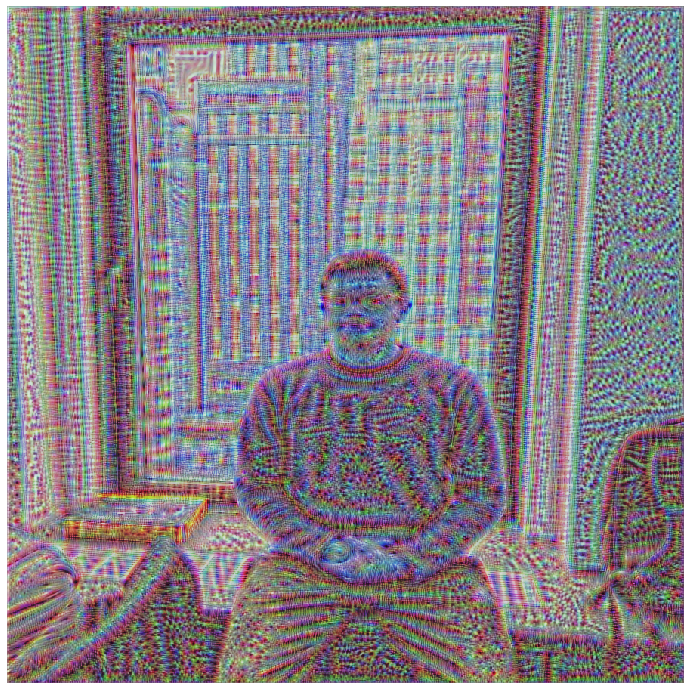

In [23]:
history = model.fit(dummy_input.repeat(1), epochs = 3)

# ImageNet
img = get_image_from_model(model)
print(f'Transmitting image')
show_image(img)

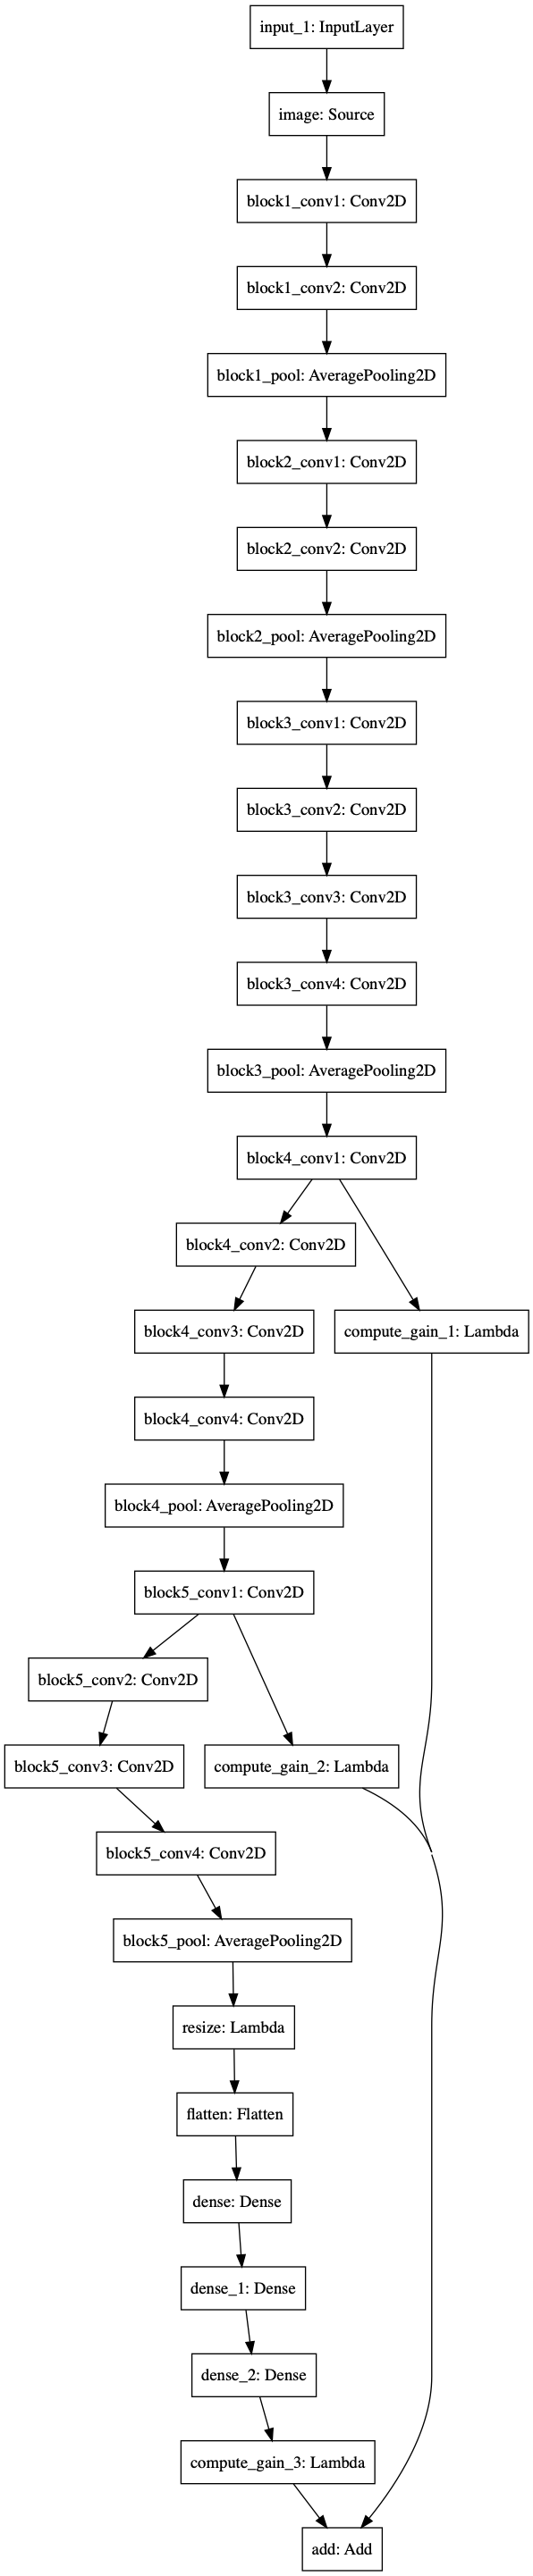

In [9]:
plot_model(model)

In [12]:
model.save('../test-model-2.hdf5')

In [ ]:
# Settings I like
    # RemainImage(0.9)
    # 'dense_2'            : 1.0,
    # 'block3_conv4'       : 0.001,
    # 'block4_conv1'       : 0.001,
    # 'block5_conv1'       : 0.001,

#No normalization, just block 4 and 5 conv_1

# Bonus: set learning rate from 10 to 100 and reduce iterations substantially
#  Example: 1 3 or 5

# Marco C: add global max pool before all loss calculations

# Version 4: Other Architectures
## Inception-v3 (the original)

In [4]:
class RemainGoogleImage(Constraint):
    def __init__(self, rate = 1.0):
        super().__init__()
        self.rate = rate
    
    def __call__(self, kernel):
        return (self.rate       * tf.clip_by_value(kernel, -1, 1) + 
                (1 - self.rate) * kernel)

class ClipGoogleImage(Constraint):
    def __init__(self):
        super().__init__()
    
    def __call__(self, kernel):
        return tf.clip_by_value(kernel, -1, 1)

In [215]:
tf.keras.backend.clear_session()

In [6]:
width = height = 299*4

In [221]:
# Load the model
base_model = tf.keras.applications.InceptionV3(include_top = False, 
                                               weights = 'imagenet', 
                                               input_shape  = (width, height, 3),
                                               pooling = None)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
plot_model(base_model)

In [304]:
output_layers = {
    'mixed5' : 100.0,
    'mixed3' : 100.0,
}

# Set up the source image
input_           = Input(shape = (), batch_size = 1)
image_layer      = Source((1, width, height, 3),
                      name = 'image', 
                      kernel_constraint = ClipGoogleImage())
input_signal     = image_layer(input_)

def get_loss(base_model_layer, weight, max_pool = False):
    signal = base_model_layer.output

    if max_pool:
        axes   = tf.range(1, tf.rank(signal))
        signal = tf.reduce_max(signal, axis = [1,2])
    # Compute the mean
    axes   = tf.range(1, tf.rank(signal))
    signal = tf.reduce_sum(signal, axis = axes)
    signal = signal * (-weight)
    return signal

losses = []
for layer_name, weight in output_layers.items():
    layer = base_model.get_layer(layer_name)
    loss  = get_loss(layer, weight, max_pool=False)
    losses.append(loss)

if len(losses) == 1:
    loss = losses[0]
else:
    loss = Add()(losses)
    

# Build main network and feed the image input
temp_model = Model(inputs = base_model.input, outputs = loss)
loss       = temp_model(input_signal)
model      = Model(inputs = input_, outputs = loss)

# Load the image with Inception v3 Preprocessing
image_path = '../dream-base-images/marco3.png'
image = load_image(image_path, cast = tf.float32)
image = inceptionV3_process_image(image)
image = tf.image.resize(image, [width, height])
image = tf.expand_dims(image, axis = 0)
image_layer.set_weights([image.numpy()])

# Set up dummy data to feed the model
dummy       = tf.constant(0, shape = (1,), dtype = tf.float32)
dummy_input = tf.data.Dataset.from_tensors((dummy, dummy))

In [305]:
@tf.function
def normalized_gradient_descent(model, learning_rate, steps):
    print('Tracing the Graph')
    loss    = tf.constant(0.0)
    weights = model.trainable_weights[0]
    image   = model.get_layer('image')
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            loss             = model(dummy)
            variational_loss = tf.image.total_variation(image(dummy)) * 0.1
            loss += variational_loss

        gradient = tape.gradient(loss, weights)

        # Normalize the gradients
        gradient /= tf.math.reduce_std(gradient) + 1e-8 

        weights.assign_sub(gradient * learning_rate        )
        weights.assign(    tf.clip_by_value(weights, -1, 1))
        
        

Tracing the Graph
19.596 seconds elapsed
Loss of -1267628032.00 achieved
Transmitting image


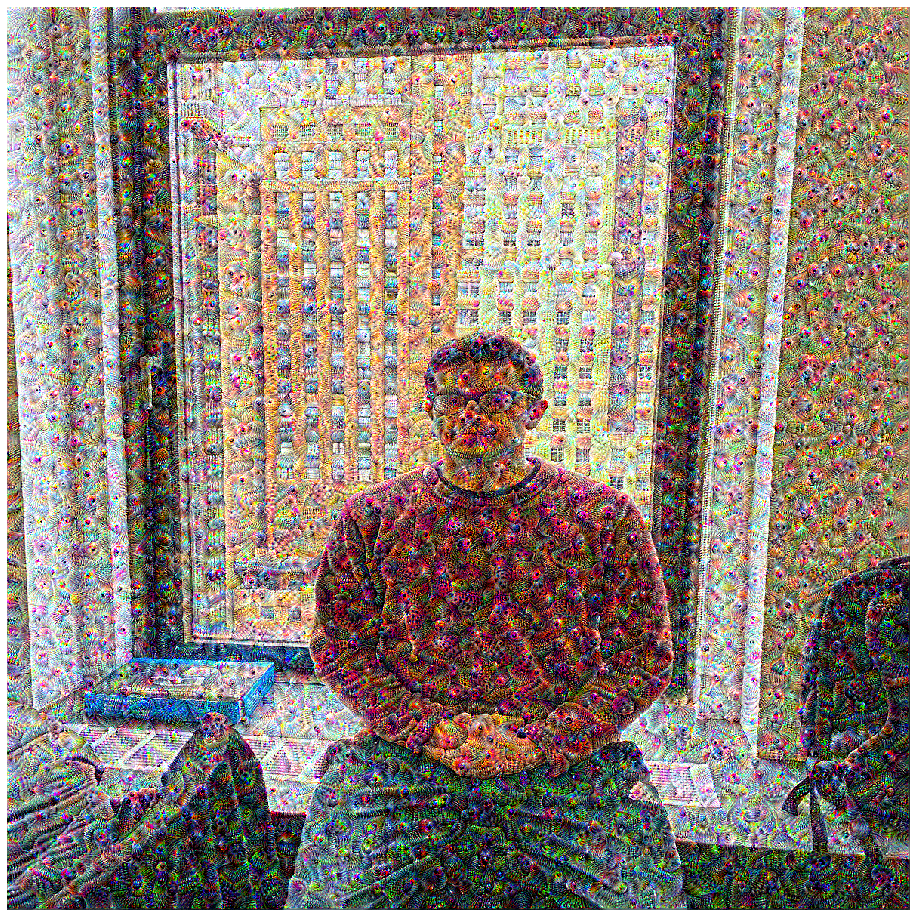

In [306]:
image_layer.set_weights([image.numpy()])
        
Timer.start()
normalized_gradient_descent(model, 0.02, 200)
Timer.end()

img = get_image_from_model(model, format_ = 'inceptionV3')
loss = model(dummy).numpy()[0]
print(f'Loss of {loss : .2f} achieved')
print(f'Transmitting image')
show_image(img)

## Variation 5:
Add style information